# Appendix 

## 1. SIgle states with higher energies
In the main text, we only consider the linear conbination of ground states as the solution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hamiltonian of sigle potential
def make_H1dp(N,xmax,xmin,V):
    mat_H = np.zeros((N, N))
    dx = (xmax-xmin)/N   
    for n in range(N):
        for i in (-1, 0, 1):
            j = n + i
            # periodic boundary consition. 
            if j >=N:
                j = 0
            if j <0:
                j = N -1
            v = 0.0 
            if i == 0:              
                v = (2/dx**2 + V[n])
            elif i == 1:
                v = -1/dx**2
            elif i == -1:
                v = -1/dx**2
            if 0 <= j and j < N:
                mat_H[n,j] = v
                
    return mat_H

In [3]:
# Give a potnential at x0
def potential_shift(x, x0, V0):
    V =  V0*np.exp(-(x-x0)**2)
    return V

In [4]:
def eigen(x_range, V0):
    N = 1000
    xmax = x_range
    xmin = -x_range
    xvec = np.linspace(xmin, xmax, N)
    # Eigenvalues for potential 1
    pot_min = (xmax-xmin)/2
    x0 = xmin+pot_min/2
    V1 = potential_shift(xvec, x0, V0)
    mat_H1 = make_H1dp(N,xmax,xmin, V1) 
    energy1,mat_v1 = np.linalg.eig(mat_H1)
    ind1 = np.argsort(energy1)
    energy1 = energy1[ind1]
    mat_v1 = mat_v1.T[ind1]

    # Eigenvalues for potential 2
    x0 = xmin+pot_min*3/2
    V2 = potential_shift(xvec, x0, V0)
    mat_H2 = make_H1dp(N,xmax,xmin, V2)
    energy2,mat_v2 = np.linalg.eig(mat_H2)
    ind2 = np.argsort(energy2)
    energy2 = energy2[ind2]
    mat_v2 = mat_v2.T[ind2]

    return energy1, mat_v1, energy2, mat_v2, V1, V2

In [5]:
def calc_Htb(cutoff, E1, E2, v1, v2, V1, V2):
    mat_Htb = np.zeros((2*cutoff,2*cutoff))
    N = len(v1[0])
    # 
    for i in range(cutoff):
        for j in range(cutoff):
            mat_Htb[i][j] = E1[j]*np.sum(v1[i]*v1[j]) + np.sum(v1[i]*V2*v1[j])
        for j in range(cutoff):
            mat_Htb[i][j + cutoff] = E2[j]*np.sum(v1[i]*v2[j]) + np.sum(v1[i]*V1*v2[j])
    # 
    for i in range(cutoff):
        for j in range(cutoff):
            mat_Htb[i+ cutoff][j] = E1[j]*np.sum(v2[i]*v1[j]) + np.sum(v2[i]*V2*v1[j])
        for j in range(cutoff):
            mat_Htb[i + cutoff][j + cutoff] = E2[j]*np.sum(v2[i]*v2[j]) + np.sum(v2[i]*V1*v2[j])
    return mat_Htb


[ 5.76447274e-01  4.05892115e-05  4.06400977e-02  1.71460701e-03
 -4.07497216e-01 -5.76447275e-01  4.05892124e-05  4.06400977e-02
  1.71460705e-03 -4.07497215e-01]


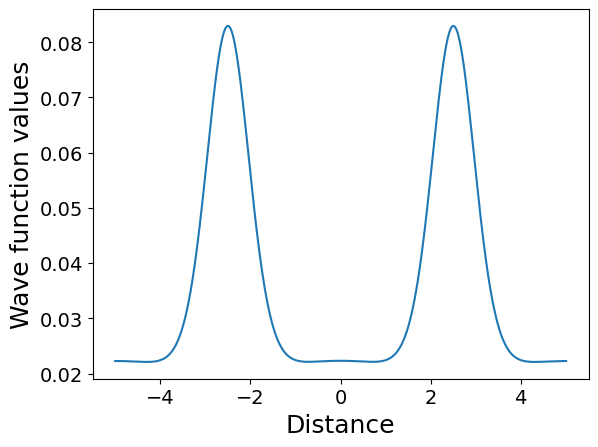

In [6]:
x_range = 5
V0 = -20.0
cutoff = 5 # considering 5 orbitals from the ground state
energy1, mat_v1, energy2, mat_v2, V1, V2 = eigen(x_range, V0)
mat_Htb = calc_Htb(cutoff, energy1, energy2, mat_v1, mat_v2, V1, V2)


# Diagonalization
ε,c1 = np.linalg.eig(mat_Htb)
ind = np.argsort(ε)
ε = ε[ind]
c1 = c1.T[ind]
val = 1
print()
print(c1[val])
wf = np.zeros(len(mat_v1[0]))
for i in range(cutoff):
    wf += c1[val][i]*mat_v1[i]
    wf += c1[val][i+cutoff]*mat_v2[i]
    
xvec = np.linspace(-x_range, x_range, 1000)
plt.plot(xvec, wf)
plt.xlabel("Distance", fontsize = 18)
plt.ylabel("Wave function values", fontsize = 18)
plt.tick_params(labelsize=14)
plt.show()

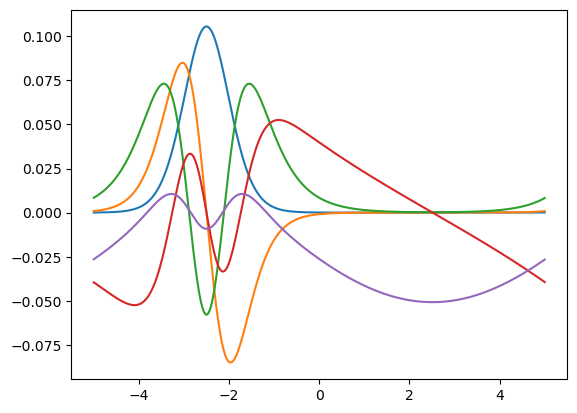

In [7]:
# plotting 0-5 states
plt.plot(xvec, mat_v1[0], label = "Ground")
plt.plot(xvec, mat_v1[1], label = "Firstexcited")
plt.plot(xvec, mat_v1[2], label = "second")
plt.plot(xvec, mat_v1[3], label = "third")
plt.plot(xvec, mat_v1[4], label = "Fouth")

## 2. Edge state in SSH model
Calculate the band with limited number of unit cells.

In [43]:
def calc_H_SSH(kx,Nc, t, dt, boundary = True):
    N = 2*Nc
    mat_H = np.zeros((N,N), dtype = complex) 

    for m in range(Nc):
        for a in (0, 1):
            num = 2*m + a
            ii = num -1
            jj = num + 1 
            if a == 0:
                t1 = -(t-dt)*np.exp(complex(0,kx))
                t2 = -(t+dt)
                if ii >= 0:
                    mat_H[num, ii] = t1
                elif boundary:
                    mat_H[num, N-1] = t1
                if jj < N:
                    mat_H[num, jj] = t2
                elif boundary:
                    mat_H[num, 0] = t2
            else:
                t1 = -(t+dt)
                t2 = -(t-dt)*np.exp(complex(0,-kx))
                if ii >= 0:
                    mat_H[num, ii] = t1
                elif boundary:
                    mat_H[num, N-1] = t1
                if jj < N:
                    mat_H[num, jj] = t2
                elif boundary:
                    mat_H[num, 0] = t2
    return mat_H


In [69]:
def calc_band(Nc,  t, dt):
    nkx = 30
    vkx = np.linspace(-np.pi, np.pi, nkx)
    ep = np.zeros((nkx,Nc*2))
    cnt = 0
    for kx in vkx:
        mat_H = calc_H_SSH(kx,Nc, t, dt, False)    
        energy, mat_v  = np.linalg.eig(mat_H)
        ind = np.argsort(energy)
        energy = energy[ind]
        mat_v = mat_v.T[ind]
        for i in range(Nc*2):
            ep[cnt,i] = energy[i]
        cnt += 1

    plt.rcParams.update(plt.rcParamsDefault)
    plt.plot(vkx,ep)
    plt.ylabel("Energy", fontsize = 18)
    plt.xlabel("kx", fontsize = 18)
    plt.tick_params(labelsize=14)
    plt.show()

C:\Users\k708a\AppData\Local\Temp\ipykernel_15808\3139567858.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  ep[cnt,i] = energy[i]


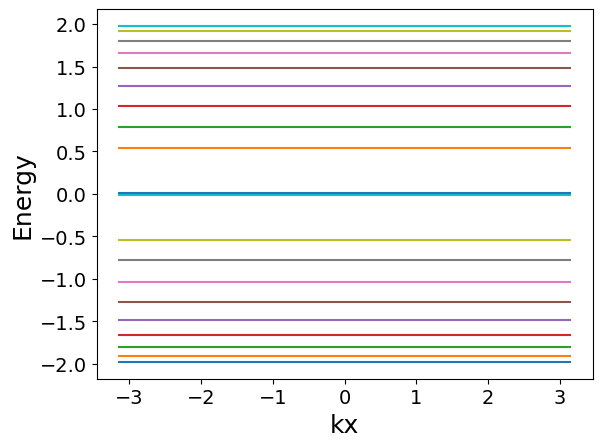

In [70]:
Nc = 10
t = 1
dt = -0.2

calc_band(Nc, t, dt)

For dt = -0.2, a band appear at E=0, that is the edge state.

C:\Users\k708a\AppData\Local\Temp\ipykernel_15808\3139567858.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  ep[cnt,i] = energy[i]


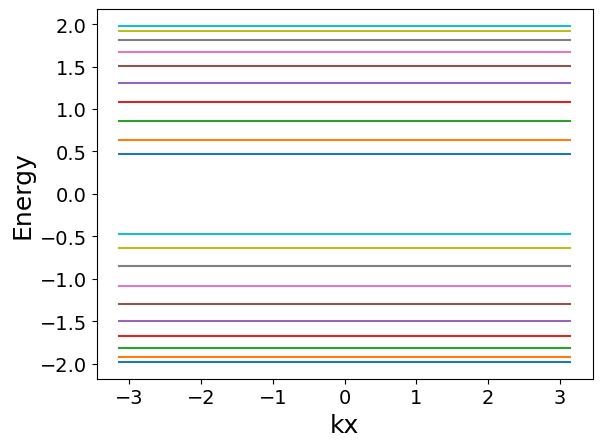

In [71]:
Nc = 10
t = 1
dt = 0.2

calc_band(Nc, t, dt)

For dt = 0.2, no state at E=0.